# Face Recognition with PCA and SVM</br>
We will use dimension reduction becuase the image dimensions are large even for a small size image(say a 50*50 image is of 2500 features)
So using PCA and LDA dimension reduction techniques, we can transform them to less dimension depending on number of components.


1.   Make faces dataset.
2.   Reduce its dimensionality using PCA and LDA.
3.   Compare/ Find optimal n_components.
4.   Train classifiers(SVM) on both components.
5.   Plot results.


# Create dataset

In [131]:
import numpy as np
import cv2
import os, re
from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imutils
from sklearn.metrics import plot_confusion_matrix

We will be using the yale dataset, specifically the Cropped one.

In [2]:
!wget http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip

--2020-06-30 10:35:38--  http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip
Resolving vision.ucsd.edu (vision.ucsd.edu)... 132.239.95.98
Connecting to vision.ucsd.edu (vision.ucsd.edu)|132.239.95.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58493820 (56M) [application/zip]
Saving to: ‘CroppedYale.zip’

CroppedYale.zip     100%[===================>]  55.78M   680KB/s    in 85s     

2020-06-30 10:37:03 (672 KB/s) - ‘CroppedYale.zip’ saved [58493820/58493820]



In [132]:
!unzip -qq /content/CroppedYale.zip

replace CroppedYale/yaleB39/WS_FTP.LOG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

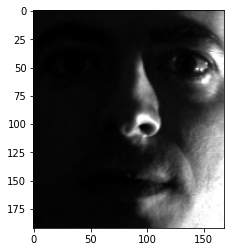

In [ ]:
# sample face
img = cv2.imread('/content/CroppedYale/yaleB06/yaleB06_P00A-110E-20.pgm')
plt.imshow(img)
plt.show()

Make Dataset

In [163]:

def make_dataset(imgs_dirs):
   imgs_mat = []
   y_ids = []
   added = 0
   for i,img_dir in enumerate(imgs_dirs):
      imgs = os.listdir(img_dir) 
      for img in imgs:
          try:
            image_mat = cv2.imread(img_dir + img)
            image_mat = cv2.cvtColor(image_mat, cv2.COLOR_BGR2GRAY)
            image_mat = imutils.resize(image_mat, width=50, height= 50)
            image_mat = np.array(image_mat).flatten()
            imgs_mat.append(image_mat)
            added+=1
          except:
            continue    
      y_ids.append(added)
      
   # make y   
   y = np.zeros(len(imgs_mat))   
   y[:y_ids[0]] = 1
   for i in range(1, len(y_ids)):
      y[y_ids[i-1]:y_ids[i]] = i+1

   return imgs_mat, y

def make_sample(img):

    image_mat = cv2.imread(img)
    image_mat = cv2.cvtColor(image_mat, cv2.COLOR_BGR2GRAY)
    image_mat = imutils.resize(image_mat, width=50, height= 50)
    image_mat = np.array(image_mat).flatten()
    image_mat = image_mat.reshape(1, 2850)
    return image_mat


In [182]:
dirs = ['/content/CroppedYale/yaleB01/', '/content/CroppedYale/yaleB02/',
        '/content/CroppedYale/yaleB03/', '/content/CroppedYale/yaleB04/',
         '/content/CroppedYale/yaleB05/', '/content/CroppedYale/yaleB06/']
X, Y = make_dataset(dirs)
print('Image shape is 57,50')
faces_mat = np.array(X)
print('Dataset has images',len(X))
print('Number for face classes',len(dirs))

Image shape is 57,50
Dataset has images 389
Number for face classes 6


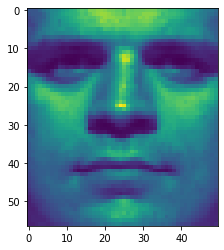

In [120]:
# sample face from created dataset

eg = X[200].reshape(57,50)
plt.imshow(eg)
plt.show()

In [183]:
# create test set

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)

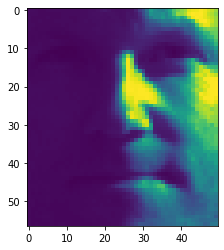

In [76]:
eg = x_test[20].reshape(57,50)
plt.imshow(eg)
plt.show()

# Dimensionality Reduction using PCA and LDA.

In [155]:
# make dummby pca to plot faces

N_COMPONENT = 2

pca = decomposition.PCA(n_components=N_COMPONENT, random_state=42)
pca_components = pca.fit_transform(X)

In [156]:
print("Variance component wise: {0}".format(pca.explained_variance_ratio_))

Variance component wise: [0.4170648  0.33340552]


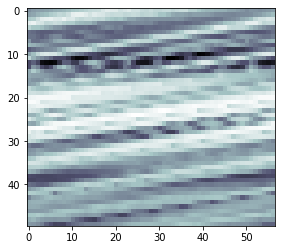

In [157]:
# mean face
plt.imshow(pca.mean_.reshape(50, 57), cmap=plt.cm.bone)
plt.show()

Mean face is not visible since there is are less samples per subject. With more samples in training face can be visible.

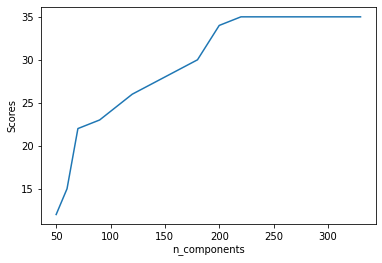

In [184]:
# find best n_component of pca

x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

n = [50,60,70,90,100,120,150,180,200,220,250,270,300,310,320,330]
scores = []
for i in n:
  pca = decomposition.PCA(n_components=i, random_state=42)
  pca_components = pca.fit_transform(x_train, y_train)
  pca_x_test = pca.transform(x_test) 
  clf = SVC(gamma='auto')
  clf.fit(pca_components, y_train)
  yhat1 = clf.predict(pca_x_test)
  scores.append(len(yhat1[y_test == yhat1]))

plt.plot(n, scores)
plt.ylabel('Scores')
plt.xlabel('n_components')
plt.show()

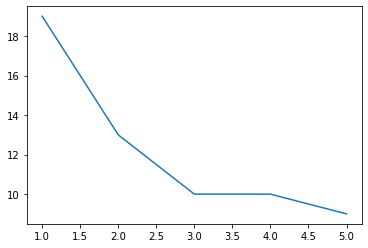

In [186]:
# find best n_component of lda

x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

n = [1,2,3,4,5]
scores = []
for i in n:
  lda = LinearDiscriminantAnalysis(n_components=i)
  lda_components = lda.fit_transform(x_train, y_train)
  lda_x_test = lda.transform(x_test) 
  clf = SVC(gamma='auto')
  clf.fit(lda_components, y_train)
  yhat1 = clf.predict(lda_x_test)
  scores.append(len(yhat1[y_test == yhat1]))

plt.plot(n, scores)
plt.show()

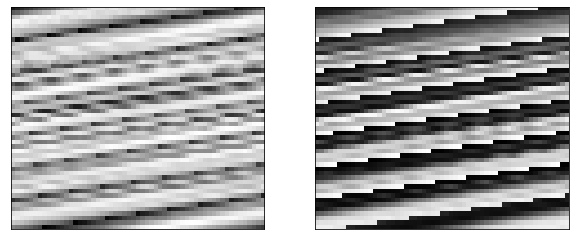

In [173]:
# show what 2 components have learned(also called eigen faces)

fig = plt.figure(figsize=(10,5))

for i in range(N_COMPONENT):
    ax = fig.add_subplot(1, N_COMPONENT, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(50,57),
              cmap='gray')

In [174]:
# rescale data then create pca

x = StandardScaler().fit_transform(x_train)
pca = decomposition.PCA(n_components=N_COMPONENT, random_state=42)
pca_components = pca.fit_transform(x, y_train)

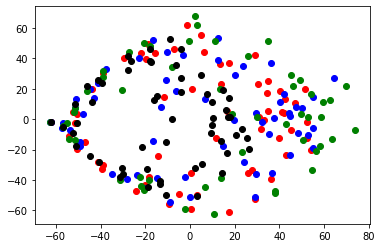

In [ ]:
# example plot 2 components with 4 classes(face classes)

plt.scatter(pca_components[y_train==1, 0], pca_components[y_train==1, 1], color=('r'))
plt.scatter(pca_components[y_train==2, 0], pca_components[y_train==2, 1], color=('b'))
plt.scatter(pca_components[y_train==3, 0], pca_components[y_train==3, 1], color=('g'))
plt.scatter(pca_components[y_train==4, 0], pca_components[y_train==4, 1], color=('black'))
plt.show()

The clusters are hard to find, we had 4 classes, the values are scattered very far away from each other.</br> Lets use LDA which has better strategy to reduce inner-class variance and increase outer-class variance.

In [ ]:
# with lda

x = StandardScaler().fit_transform(x_train)
lda = LinearDiscriminantAnalysis(n_components=N_COMPONENT)
lda_components = lda.fit_transform(x, y_train)
print('Components variance ratio: ',lda.explained_variance_ratio_)
print('Almost ~23% of data loss')

Components variance ratio:  [0.41229892 0.37108143]
Almost ~23% of data loss


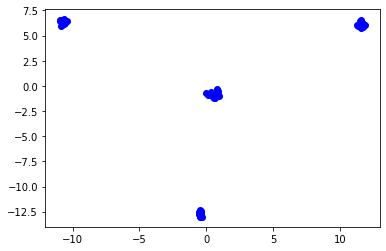

In [ ]:
# plot lda

plt.scatter(lda_components[:, 0], lda_components[:, 1], color=('b'))
plt.show()

As here the clusters are well recognized. This processed data can be further used to train a classifier.

# Train a classifier(SVM)


In [189]:
# train a classifier to detect faces
# pca

x = StandardScaler().fit_transform(x_train)

pca = decomposition.PCA(n_components=220, random_state=42)
pca_components = pca.fit_transform(x, y_train)
clf1 = SVC(gamma='auto')
clf1.fit(pca_components, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [190]:
# lda

lda = LinearDiscriminantAnalysis(n_components=2)
lda_components = lda.fit_transform(x, y_train)

clf2 = SVC(gamma='auto')
clf2.fit(lda_components, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [191]:
# predict with both classifiers

x_test = StandardScaler().fit_transform(x_test)

pca_x_test = pca.transform(x_test) 
lda_x_test = lda.transform(x_test) 

yhat1 = clf1.predict(pca_x_test)
yhat2 = clf2.predict(lda_x_test)

In [192]:
print('PCA: {0} Correct out of {1}'.format(len(yhat1[y_test == yhat1]), len(y_test)))

print('LDA: {0} Correct out of {1}'.format(len(yhat2[y_test == yhat2]), len(y_test)))

PCA: 35 Correct out of 39
LDA: 13 Correct out of 39


Due to lack of training data per subject the results are a bit poor. Also the faces in this dataset have different illuminations that might be affecting the PCA and LDA. With Deep Learning the results can be much better but still it will require many more faces to train on. 

# Plot results.


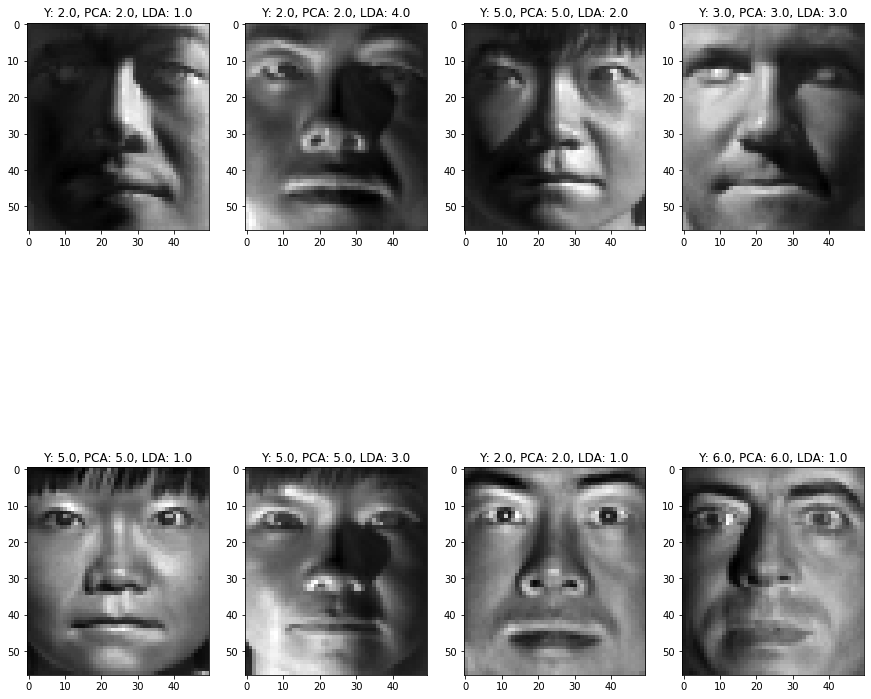

In [193]:
# lets plot images with results

results = {'Y': y_test,
           'PCA': yhat1,
           'LDA': yhat2}
rows = 2
cols = 4
f, axs = plt.subplots(rows, cols)
# f.tight_layout()
f.set_figheight(15)
f.set_figwidth(15)

a= 0

for i in range(rows):
  for j in range(cols):
    axs[i,j].imshow(x_test[a].reshape(57, 50), cmap='gray')
    axs[i,j].set_title("Y: {0}, PCA: {1}, LDA: {2}".format(results['Y'][a], results['PCA'][a], results['LDA'][a]))
    a+=1


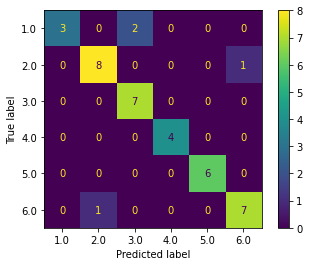

In [194]:
# also confusion matrix

plot_confusion_matrix(clf1, pca_x_test, y_test)

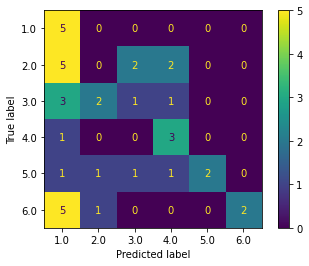

In [195]:
# lda confusion matrix

plot_confusion_matrix(clf2, lda_x_test, y_test)

Summary: 
While using Face recognition with Classic machine learning(No Deep learning), PCA results were fine. One thing to notice is some faces are misclssified by pca but lda has predicted them right, which is a good sign for making emsembles of such models. Given one model more(so total 3) one can make ensembles work and which can improve results.
Notes:
*   Take faces cropped images.
*   Take many faces per subject(>50 or 100).
*   Take faces with same illuminations(Similar lighting conditions).
* Make use of ensemble.
*   Use Deep learning for bigger task.

